In [1]:
# installation via PyPI
!pip install -U mobile-env
!pip install numpngw # for video render

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00


In [2]:
import warnings
# Ignoring a specific deprecation warning
warnings.filterwarnings("ignore")

In [3]:
import gymnasium
import matplotlib.pyplot as plt
import mobile_env
import numpy as np
from numpngw import write_apng
from IPython.display import Image, display
import seaborn as sns
sns.set_style("whitegrid")


# Monitoring Measurments

In [4]:
# overall number of active connections
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}


# monitors each user equipments' distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestations
    bpos = np.array([[bs.x, bs.y] for bs in sim.stations.values()])

    distances = {}
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2, axis=1)).min()

        distances[ue_id] = dist

    return distances


# number of connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}


# Add new feature (any_connection) to observation space

In [5]:
from mobile_env.handlers.central import MComCentralHandler
import numpy as np


class CustomHandler(MComCentralHandler):
    # new observation "any_connection"
    features = MComCentralHandler.features + ["any_connection"]

    # overwrite the observation size per user
    @classmethod
    def ue_obs_size(cls, env) -> int:
        """Increase observations by 1 for each user for the new obs"""
        # previously: connections for all cells, SNR for all cells, utility
        prev_size = env.NUM_STATIONS + env.NUM_STATIONS + 1
        return prev_size + 1

    # add the new observation
    @classmethod
    def observation(cls, env) -> np.ndarray:
        """Concatenated observations for all users"""
        # get all available obs from the env
        obs_dict = env.features()

        # add the new observation for each user (ue)
        for ue_id in obs_dict.keys():
            any_connection = np.any(obs_dict[ue_id]["connections"])
            obs_dict[ue_id]["any_connection"] = int(any_connection)

        # select the relevant obs and flatten into single vector
        flattened_obs = []
        for ue_id, ue_obs in obs_dict.items():
            flattened_obs.extend(ue_obs["connections"])
            flattened_obs.append(ue_obs["any_connection"])
            flattened_obs.extend(ue_obs["snrs"])
            flattened_obs.extend(ue_obs["utility"])

        return flattened_obs

# Create Custom environment

In [6]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment

class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # "width": 100,
            # "height": 100,
            # 10 steps per episode
            "EP_MAX_TIME": 100,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
            "metrics": {
            "scalar_metrics": {"overall connections": overall_connections},
            "ue_metrics": {"user utility": user_utility, 'distance station': user_closest_distance},
            "bs_metrics": {"station connections": station_connections}
            },
            "handler": CustomHandler
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        config["bs"].update({
            "tx": 35,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(100, 100), **env_config["bs"])
            # BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
            # stationary user --> set velocity to 0
            # UserEquipment(ue_id=3, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
            #               height=env_config["ue"]["height"]),
            # UserEquipment(ue_id=3, **env_config["ue"]),
        ]

        super().__init__(stations, users, config, render_mode)

In [7]:
env = CustomEnv(render_mode="rgb_array")
print(env.observation_space)
print(env.action_space)

Box(-1.0, 1.0, (8,), float32)
MultiDiscrete([2 2])


In [ ]:
env = CustomEnv(render_mode="rgb_array")
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

print("Raw observations: ", obs)

# connections and SNR are per user and station, utility just per user
obs_per_user = 2 * env.NUM_STATIONS + 2
for ue in range(env.NUM_USERS):
    print(f"\nObservations for user {ue + 1}:")
    offset = ue * obs_per_user
    print(f"Current connections to the {env.NUM_STATIONS} cells: {obs[offset:offset+env.NUM_STATIONS]}")
    print(f"NEW: Any connection?: {obs[offset+env.NUM_STATIONS]}")
    print(f"SNR to the {env.NUM_STATIONS} cells: {obs[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]}")
    print(f"Current utility: {obs[offset+2*env.NUM_STATIONS+1]}")

Raw observations:  [0.0, 0, 1.0, -1.0, 1.0, 1, 1.0, 0.10279423]

Observations for user 1:
Current connections to the 1 cells: [0.0]
NEW: Any connection?: 0
SNR to the 1 cells: [1.0]
Current utility: -1.0

Observations for user 2:
Current connections to the 1 cells: [1.0]
NEW: Any connection?: 1
SNR to the 1 cells: [1.0]
Current utility: 0.10279422998428345


[1 0]


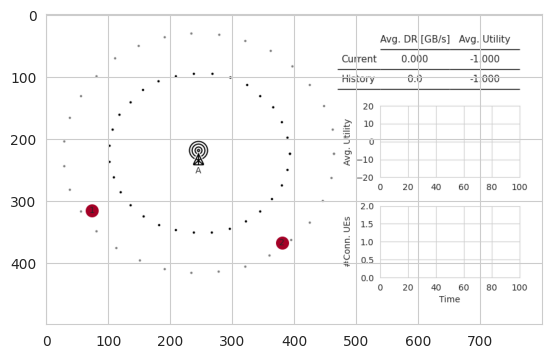

In [ ]:
env.reset()
action = env.action_space.sample()
print(action)
env.step(action)
plt.imshow(env.render());

In [ ]:
env.features()

{1: {'connections': array([0.], dtype=float32),
  'snrs': array([1.], dtype=float32),
  'utility': array([-1.], dtype=float32),
  'bcast': array([-1.], dtype=float32),
  'stations_connected': array([0.], dtype=float32)},
 2: {'connections': array([0.], dtype=float32),
  'snrs': array([1.], dtype=float32),
  'utility': array([-1.], dtype=float32),
  'bcast': array([-1.], dtype=float32),
  'stations_connected': array([0.], dtype=float32)}}

The Q-learning update equation:

$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') ]$

The ϵ-greedy action selection:

$\pi(a|s) =
\begin{cases}
	1 - \epsilon + \frac{\epsilon}{|\mathcal{A}(s)|} & \text{if } a = \arg\max_{a'} Q(s, a') \\
	\frac{\epsilon}{|\mathcal{A}(s)|} & \text{otherwise}
\end{cases}$

In [ ]:
class QLearningAgent:
  def __init__(self, NUM_USERS, NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, learning_rate=0.01, discount_factor=0.9, exploration_prob=1, epsilon_greedy=False):
    self.NUM_USERS = NUM_USERS
    self.NUM_STATIONS = NUM_STATIONS
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.exploration_prob = exploration_prob
    self.epsilon_greedy = epsilon_greedy


    self.num_action = []
    for _ in range(NUM_USERS):
      self.num_action.append(self.NUM_STATIONS+1)

    # Initialize Q-table with zeros
    self.q_table = np.zeros(DISCRETE_OS_SIZE + self.num_action)

  def select_action(self, state):
    # Exploration-exploitation trade-off
    if self.epsilon_greedy:
      probs = self.policy(state)
      index = np.random.choice(np.arange(np.prod(self.num_action)), p=probs.flatten())
      action = np.unravel_index(index, self.num_action)
      return action
    else:
      if np.random.uniform(0, 1) < self.exploration_prob:
        rand_action=[]
        for _ in range(self.NUM_USERS):
          rand_action.append(np.random.randint(0, self.NUM_STATIONS+1))
        return np.array(rand_action)
      else:
        discrete_state = self.get_discrete_state(state)
        best_action = np.unravel_index(np.argmax(self.q_table[discrete_state]), self.q_table[discrete_state].shape) # unravel_index is used for convert an index (3) to 3d-index (0,1,0)
        return best_action

  def update_q_table(self, state, action, reward, next_state):
    # Q-value update using the Bellman equation
    discrete_state = self.get_discrete_state(state)
    discrete_next_state = self.get_discrete_state(next_state)
    best_next_action = np.unravel_index(np.argmax(self.q_table[discrete_next_state]), self.q_table[discrete_next_state].shape)
    current_q_value = self.q_table[discrete_state][action]
    new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[discrete_next_state][best_next_action])
    self.q_table[discrete_state][action] = new_q_value

  def get_discrete_state(self, state):
    # To convert continuous state to index of Q table
    discrete_state = np.zeros(np.array(state).shape[0])
    obs_per_user = 2 * self.NUM_STATIONS + 2
    for ue in range(self.NUM_USERS):
      offset = ue * obs_per_user
      discrete_state[offset:offset+self.NUM_STATIONS] = state[offset:offset+self.NUM_STATIONS] #Connection
      discrete_state[offset+env.NUM_STATIONS] = state[offset+env.NUM_STATIONS]
      discrete_state[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1] = (state[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1] - DISCRETE_LOW[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1])/discrete_os_win_size[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1] # SNR
      discrete_state[offset+2*env.NUM_STATIONS+1] = (state[offset+2*env.NUM_STATIONS+1] - DISCRETE_LOW[offset+2*env.NUM_STATIONS+1])/discrete_os_win_size[offset+2*env.NUM_STATIONS+1]  # Utility

      discrete_state[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1] = [4 if x == 5 else x for x in discrete_state[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]]

      if discrete_state[offset+2*env.NUM_STATIONS+1] == 10:
        discrete_state[offset+2*env.NUM_STATIONS+1] = 9

    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the Q values for the available actions in the q-table

  def policy(self, state):
    # returns the probabilities for each action
    A = np.ones(self.num_action, dtype=float) * self.exploration_prob / np.prod(self.num_action)
    discrete_state = self.get_discrete_state(state)
    best_action = np.unravel_index(np.argmax(self.q_table[discrete_state]), self.q_table[discrete_state].shape) # unravel_index is used for convert an index (3) to 3d-index (0,1,0)
    A[best_action] += (1.0 - self.exploration_prob)
    return A

# Structure of observation
The Structure of observation is [UE1], [UE2] ..., [UEn]

[UE] = [Status of connection to each BS], [Received SNR from each BS], [Utility]
[Status of connection to each BS] = [BS1, BS2, ..., BSn] => Each element is binary, 0 means UE is not connected to the BS and 1 means UE is connected to the BS.

[Received SNR from each BS] = [SNR1, SNR2, ..., SNRn] = > Each element is between [0,1], SNR1 means received SNR to the UE from BS1

[Utility] is a number between [-1,1] which is total utility of the UE (by considering all connected BS. To measure QoE, it is a logarithmic utility function.

In [ ]:
obs_per_user = 2 * env.NUM_STATIONS + 2
DISCRETE_OS_SIZE = np.zeros(env.observation_space.shape[0])
DISCRETE_LOW = np.zeros(env.observation_space.shape[0])
DISCRETE_HIGH = np.zeros(env.observation_space.shape[0])

for ue in range(env.NUM_USERS):
  offset = ue * obs_per_user
  DISCRETE_OS_SIZE[offset:offset+env.NUM_STATIONS] = 2*np.ones(env.NUM_STATIONS) #Current connections
  DISCRETE_OS_SIZE[offset+env.NUM_STATIONS] = 2
  DISCRETE_OS_SIZE[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]= 5 * np.ones(env.NUM_STATIONS) # SNR
  DISCRETE_OS_SIZE[offset+2*env.NUM_STATIONS+1] = 10 # Utility

  DISCRETE_LOW[offset:offset+env.NUM_STATIONS] = 0*np.ones(env.NUM_STATIONS) #Current connections
  DISCRETE_LOW[offset+env.NUM_STATIONS] = 0
  DISCRETE_LOW[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]= 0 * np.ones(env.NUM_STATIONS) # SNR
  DISCRETE_LOW[offset+2*env.NUM_STATIONS+1] = -1 # Utility

  DISCRETE_HIGH[offset:offset+env.NUM_STATIONS] = 1*np.ones(env.NUM_STATIONS) #Current connections
  DISCRETE_HIGH[offset+env.NUM_STATIONS] = 1
  DISCRETE_HIGH[offset+env.NUM_STATIONS+1:offset+2*env.NUM_STATIONS+1]= 1*np.ones(env.NUM_STATIONS) # SNR
  DISCRETE_HIGH[offset+2*env.NUM_STATIONS+1] = 1 # Utility

# the DISCRETE_OS_SIZE is used to convert continuous observation to a discrete value.
discrete_os_win_size = (DISCRETE_HIGH - DISCRETE_LOW)/DISCRETE_OS_SIZE
DISCRETE_OS_SIZE = DISCRETE_OS_SIZE.astype(int).tolist()
print("DISCRETE_OS_SIZE: ", DISCRETE_OS_SIZE)


DISCRETE_OS_SIZE:  [2, 2, 5, 10, 2, 2, 5, 10]


In [ ]:
def runner(agent, env):
  frames = []
  selected_actions=[]
  obs, info = env.reset()
  scalar_results_list=[]
  ue_results_list =[]
  bs_results_list=[]
  num_episodes= 30000
  for i in range(num_episodes):

    selected_action = agent.select_action(obs)
    selected_actions.append(selected_action)

    new_obs, reward, terminated, truncated, info = env.step(selected_action)
    agent.update_q_table(obs, selected_action, reward, new_obs)
    obs = new_obs

    # render the environment
    if i>num_episodes - 100:
      frames.append(env.render())

    if terminated or truncated:
      # Save monitoring
      scalar_results, ue_results, bs_results = env.monitor.load_results()
      scalar_results_list.append(scalar_results)
      ue_results_list.append(ue_results)
      bs_results_list.append(bs_results)
      # decay epsilon
      if agent.exploration_prob >= 0.02:
        agent.exploration_prob = agent.exploration_prob * 0.985
      obs, info = env.reset()

  env.close()
  return frames, scalar_results_list, ue_results_list, bs_results_list , selected_actions

In [ ]:
def plot_anim(frames, name):
  write_apng(name, frames, delay=80)  # real-time rendering = 40 ms between frames
  display(Image(filename=name))

In [ ]:
def plot_reward(scalar_results_list):
  rewards = [scalar_results["mean utility"] for scalar_results in scalar_results_list]
  concatenated_rewards = [item for sublist in rewards for item in sublist]
  plt.plot(concatenated_rewards)
  plt.title("Rewards")
  plt.show()
  return concatenated_rewards

In [ ]:
def plot_reward_per_episode(scalar_results_list):
  rewards = [scalar_results["mean utility"] for scalar_results in scalar_results_list]
  for i, reward in enumerate(rewards):
    plt.plot(reward, label=f"Episode {i}")
  plt.title("Rewards per episode")
  plt.legend()
  plt.show()
  sums = [sum(sublist)/len(sublist) for sublist in rewards]
  print("Average rewards per episode: ", sums)

In [ ]:
def metric_per_user(ue_results_list):
  for i, ue_results in enumerate(ue_results_list):
    data = ue_results_list[i].reset_index()
    data = data.groupby('UE ID').agg(['mean', 'min', 'max'])
    data = data.drop('Time Step', axis='columns')
    print(f"episode {i}:", data.head())

In [ ]:
def sum_reward(scalar_results_list):
  rewards = [scalar_results["mean utility"].sum() for scalar_results in scalar_results_list]
  plt.plot(rewards)
  plt.title("Sum of rewards per episode")
  plt.show()
  print("Sum of rewards per episode: ", rewards)
  return rewards

In [ ]:
agent = QLearningAgent(env.NUM_USERS, env.NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, discount_factor=0.9, epsilon_greedy=True)
env = CustomEnv(render_mode="rgb_array")
frames, scalar_results_list, ue_results_list, bs_results_list, selected_actions = runner(agent, env)

plot_anim(frames, "anim_last.png")

# reward9 = plot_reward(scalar_results_list)
# plot_reward_per_episode(scalar_results_list)
# metric_per_user(ue_results_list)
reward9 = sum_reward(scalar_results_list)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
agent = QLearningAgent(env.NUM_USERS, env.NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, discount_factor=0.7, epsilon_greedy=True)
env = CustomEnv(render_mode="rgb_array")
frames, scalar_results_list, ue_results_list, bs_results_list, selected_actions = runner(agent, env)

plot_anim(frames, "anim_first.png")
# reward7 = plot_reward(scalar_results_list)
# plot_reward_per_episode(scalar_results_list)
# metric_per_user(ue_results_list)
reward7 = sum_reward(scalar_results_list)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
agent = QLearningAgent(env.NUM_USERS, env.NUM_STATIONS, DISCRETE_OS_SIZE, discrete_os_win_size, discount_factor=0.5, epsilon_greedy=True)
env = CustomEnv(render_mode="rgb_array")
frames, scalar_results_list, ue_results_list, bs_results_list, selected_actions = runner(agent, env)

plot_anim(frames, "anim_last.png")

# reward5 = plot_reward(scalar_results_list)
# plot_reward_per_episode(scalar_results_list)
# metric_per_user(ue_results_list)
reward5 = sum_reward(scalar_results_list)

Output hidden; open in https://colab.research.google.com to view.

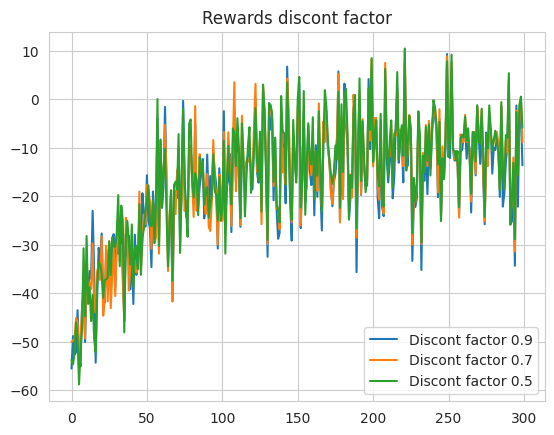

In [ ]:
plt.plot(reward9, label=f"Discont factor 0.9")
plt.plot(reward7, label=f"Discont factor 0.7")
plt.plot(reward5, label=f"Discont factor 0.5")
plt.title("Rewards discont factor")
plt.legend()
plt.show()

In [ ]:
print("Average reward with discont factor =0.9: ", sum(reward9)/len(reward9))
print("Average reward with discont factor =0.7: ", sum(reward7)/len(reward7))
print("Average reward with discont factor =0.5: ", sum(reward5)/len(reward5))

Average reward with discont factor =0.9:  -17.694374965809573
Average reward with discont factor =0.7:  -16.794876352623156
Average reward with discont factor =0.5:  -16.24947194922363
